<h1>Automatic Identification of Lithology using Machine Learning Approach</h1>

**Team 4 (Ahmed H. Gowida, Mahmoud H. Desouky, Abdullah M. Alqubalee)**

<i>Email Addresses:
AHG: g201708730@kfupm.edu.sa
MHD: g201706310@kfupm.edu.sa
AMA: g201304210@kfupm.edu.sa<i>




**Part one : Exploratory Data Analysis**

In [1]:
#import the dataset
import pandas as pd
import numpy as np

col_names= ['SitID', 'Depth','LithID', 'W_Tar', 'SW', 'VSH', 'PHI', 'RW']
dataset = pd.read_csv('INTELLOG.txt',delimiter="\t", names= col_names)

#unique values of each variable
dataset.nunique()

SitID      2175
Depth     57186
LithID        7
W_Tar       505
SW          962
VSH        1001
PHI         437
RW         4925
dtype: int64

In [2]:
# unique wells and shape of the dataset
dataset.SitID.nunique(), dataset.shape

(2175, (579846, 8))

In [3]:
# this is the legend of the lithology
lithology = pd.read_csv('Lithology_dic.TXT',delimiter="\t")
lithology

,LithID,Description
0,0,Undefined
1,1,Sand
2,2,ShalySand
3,3,SandyShale
4,4,Shale
5,5,Coal
6,6,CementedSand


In [4]:
# select the list of wells to work on
import lasio
import os

las_file_list = []

# View contents of the path, we will see LAS files plus an ASCII file
files = os.listdir('Logs/')

#how many las files do we have?
len(files)

# get files based on a condition
for file in files:
    #choose las files of wells from the same region
    #we have identifier for each region, ex. North>>(T 91-104 ,R 5-21W4)
    if '5W5' in file:
        las_file_list.append(file)

#remove the well with incomplete data
las_file_list.remove('00-04-12-072-05W5-0.LAS')
las_file_list

['00-01-01-073-05W5-0.LAS',
 '00-02-01-074-05W5-0.LAS',
 '00-02-26-073-05W5-0.LAS',
 '00-03-19-081-05W5-0.LAS',
 '00-04-21-074-05W5-0.LAS',
 '00-05-18-071-05W5-0.LAS',
 '00-05-20-070-05W5-0.LAS']

In [5]:
#how the data in the las file looks like
las = lasio.read('Logs/00-01-01-073-05W5-0.LAS')
lasdf = las.df()
lasdf

,DPHI,NPHI,GR,CALI,ILD
DEPT,,,,,
390.00,0.199,0.457,82.478,238.379,2.923
390.25,0.208,0.456,86.413,238.331,2.925
390.50,0.246,0.452,90.229,238.069,2.917
390.75,0.266,0.475,90.944,238.752,2.898
391.00,0.287,0.484,88.866,239.724,2.890
...,...,...,...,...,...
649.00,0.007,0.098,41.662,264.141,16.559
649.25,0.017,0.111,46.210,264.697,15.834
649.50,0.023,0.126,51.129,265.467,14.449


In [6]:
#we need to get the corrsponding SitID as this is the primary key with which we will join tables
wells= pd.read_csv('WELLS.txt',delimiter="\t")
wells['UWI'] = wells.UWI.str.replace('/', '-')+'.LAS'
selected = wells[wells['UWI'].isin(las_file_list)]
selected

,SitID,UWI (AGS),UWI
276,105987,0705052005000,00-05-20-070-05W5-0.LAS
387,106840,0715051805000,00-05-18-071-05W5-0.LAS
598,142218,0735050101000,00-01-01-073-05W5-0.LAS
600,108294,0735052602000,00-02-26-073-05W5-0.LAS
701,163925,0745050102000,00-02-01-074-05W5-0.LAS
703,108911,0745052104000,00-04-21-074-05W5-0.LAS
1351,113258,0815051903000,00-03-19-081-05W5-0.LAS


In [7]:
# generate dataframes from these las, 
# a fxn to import las files and 
df_list = []
for lasfile in las_file_list:
    las = lasio.read('Logs/'+lasfile)
    lasdf = las.df()
    lasdf['UWI']= lasfile
    lasdf['Depth']= lasdf.index
    df_list.append(lasdf)
    
#concatenate the dfs
las_data = pd.concat(df_list)
las_data

,DPHI,NPHI,GR,CALI,ILD,UWI,Depth
DEPT,,,,,,,
390.00,0.199,0.457,82.478,238.379,2.923,00-01-01-073-05W5-0.LAS,390.00
390.25,0.208,0.456,86.413,238.331,2.925,00-01-01-073-05W5-0.LAS,390.25
390.50,0.246,0.452,90.229,238.069,2.917,00-01-01-073-05W5-0.LAS,390.50
390.75,0.266,0.475,90.944,238.752,2.898,00-01-01-073-05W5-0.LAS,390.75
391.00,0.287,0.484,88.866,239.724,2.890,00-01-01-073-05W5-0.LAS,391.00
...,...,...,...,...,...,...,...
884.00,0.022,0.160,52.676,160.512,6.824,00-05-20-070-05W5-0.LAS,884.00
884.25,0.033,0.163,50.592,160.231,8.004,00-05-20-070-05W5-0.LAS,884.25
884.50,0.038,0.165,50.917,160.049,8.529,00-05-20-070-05W5-0.LAS,884.50


In [8]:
las_data_SitID = pd.merge(las_data, selected, on= 'UWI')
las_data_SitID

,DPHI,NPHI,GR,CALI,ILD,UWI,Depth,SitID,UWI (AGS)
0,0.199,0.457,82.478,238.379,2.923,00-01-01-073-05W5-0.LAS,390.00,142218,0735050101000
1,0.208,0.456,86.413,238.331,2.925,00-01-01-073-05W5-0.LAS,390.25,142218,0735050101000
2,0.246,0.452,90.229,238.069,2.917,00-01-01-073-05W5-0.LAS,390.50,142218,0735050101000
3,0.266,0.475,90.944,238.752,2.898,00-01-01-073-05W5-0.LAS,390.75,142218,0735050101000
4,0.287,0.484,88.866,239.724,2.890,00-01-01-073-05W5-0.LAS,391.00,142218,0735050101000
...,...,...,...,...,...,...,...,...,...
6815,0.022,0.160,52.676,160.512,6.824,00-05-20-070-05W5-0.LAS,884.00,105987,0705052005000
6816,0.033,0.163,50.592,160.231,8.004,00-05-20-070-05W5-0.LAS,884.25,105987,0705052005000
6817,0.038,0.165,50.917,160.049,8.529,00-05-20-070-05W5-0.LAS,884.50,105987,0705052005000
6818,0.035,0.169,50.256,159.877,8.832,00-05-20-070-05W5-0.LAS,884.75,105987,0705052005000


In [9]:
data = pd.merge(dataset,las_data_SitID, on= ['Depth', 'SitID'])
data

,SitID,Depth,LithID,W_Tar,SW,VSH,PHI,RW,DPHI,NPHI,GR,CALI,ILD,UWI,UWI (AGS)
0,105987,827.00,4,0.000,1.000,0.542,0.174,0.3710,0.130,0.434,83.054,171.721,1.477,00-05-20-070-05W5-0.LAS,0705052005000
1,105987,827.25,2,0.000,1.000,0.454,0.149,0.3710,0.095,0.365,77.698,165.057,1.728,00-05-20-070-05W5-0.LAS,0705052005000
2,105987,827.50,2,0.000,1.000,0.492,0.125,0.3710,0.074,0.351,79.999,161.482,2.081,00-05-20-070-05W5-0.LAS,0705052005000
3,105987,827.75,4,0.000,1.000,0.612,0.121,0.3710,0.098,0.368,87.303,161.205,2.842,00-05-20-070-05W5-0.LAS,0705052005000
4,105987,828.00,4,0.000,1.000,0.662,0.128,0.3710,0.117,0.385,90.406,161.541,3.389,00-05-20-070-05W5-0.LAS,0705052005000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,163925,627.00,6,0.000,1.000,0.198,0.305,0.5680,0.601,0.754,35.840,288.594,3.693,00-02-01-074-05W5-0.LAS,0745050102000
1151,163925,627.25,6,0.000,1.000,0.292,0.269,0.5680,0.428,0.532,43.378,261.619,4.055,00-02-01-074-05W5-0.LAS,0745050102000
1152,163925,627.50,4,0.000,1.000,0.511,0.186,0.5680,0.350,0.451,60.871,251.138,5.018,00-02-01-074-05W5-0.LAS,0745050102000
1153,163925,627.75,2,0.000,1.000,0.409,0.225,0.5680,0.323,0.476,52.736,247.416,6.550,00-02-01-074-05W5-0.LAS,0745050102000


In [10]:
data.drop(labels= ['UWI', 'UWI (AGS)'], axis=1, inplace= True)
data

,SitID,Depth,LithID,W_Tar,SW,VSH,PHI,RW,DPHI,NPHI,GR,CALI,ILD
0,105987,827.00,4,0.000,1.000,0.542,0.174,0.3710,0.130,0.434,83.054,171.721,1.477
1,105987,827.25,2,0.000,1.000,0.454,0.149,0.3710,0.095,0.365,77.698,165.057,1.728
2,105987,827.50,2,0.000,1.000,0.492,0.125,0.3710,0.074,0.351,79.999,161.482,2.081
3,105987,827.75,4,0.000,1.000,0.612,0.121,0.3710,0.098,0.368,87.303,161.205,2.842
4,105987,828.00,4,0.000,1.000,0.662,0.128,0.3710,0.117,0.385,90.406,161.541,3.389
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,163925,627.00,6,0.000,1.000,0.198,0.305,0.5680,0.601,0.754,35.840,288.594,3.693
1151,163925,627.25,6,0.000,1.000,0.292,0.269,0.5680,0.428,0.532,43.378,261.619,4.055
1152,163925,627.50,4,0.000,1.000,0.511,0.186,0.5680,0.350,0.451,60.871,251.138,5.018
1153,163925,627.75,2,0.000,1.000,0.409,0.225,0.5680,0.323,0.476,52.736,247.416,6.550


In [11]:
#remove leading spaces
data.RW.str.strip(' ')

#transform objects into float
data['RW'] = data['RW'].str.extract(r'(\d+.\d+)').astype('float')
data.RW.unique()

array([0.371, 0.37 , 0.369, 0.368, 0.367, 0.366, 0.365, 0.364, 0.363,
       0.362, 0.271, 0.27 , 0.269, 0.268, 0.267,   nan, 0.393, 0.392,
       0.391, 0.39 , 0.389, 0.388, 0.387, 0.386, 0.628, 0.627, 0.626,
       0.625, 0.624, 0.623, 0.622, 0.621, 0.62 , 0.488, 0.487, 0.486,
       0.485, 0.484, 0.442, 0.441, 0.44 , 0.439, 0.438, 0.437, 0.436,
       0.435, 0.434, 0.433, 0.432, 0.431, 0.43 , 0.429, 0.428, 0.427,
       0.426, 0.425, 0.424, 0.423, 0.422, 0.421, 0.42 , 0.419, 0.479,
       0.478, 0.477, 0.476, 0.475, 0.474, 0.473, 0.472, 0.471, 0.47 ,
       0.469, 0.587, 0.586, 0.585, 0.584, 0.583, 0.582, 0.581, 0.58 ,
       0.579, 0.578, 0.577, 0.576, 0.575, 0.574, 0.573, 0.572, 0.571,
       0.57 , 0.569, 0.568])

In [12]:
#drop the null values in the data
data.dropna(inplace=True)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 0 to 1154
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SitID   881 non-null    int64  
 1   Depth   881 non-null    float64
 2   LithID  881 non-null    int64  
 3   W_Tar   881 non-null    float64
 4   SW      881 non-null    float64
 5   VSH     881 non-null    float64
 6   PHI     881 non-null    float64
 7   RW      881 non-null    float64
 8   DPHI    881 non-null    float64
 9   NPHI    881 non-null    float64
 10  GR      881 non-null    float64
 11  CALI    881 non-null    float64
 12  ILD     881 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 96.4 KB


In [14]:
descriptive= data[['SW', 'VSH', 'PHI', 'GR', 'RW', 'CALI']].describe()
descriptive

,SW,VSH,PHI,GR,RW,CALI
count,881.000000,881.000000,881.00000,881.000000,881.000000,881.000000
mean,0.973053,0.608296,0.12357,77.186765,0.450431,225.919499
std,0.080714,0.261875,0.07447,21.264507,0.103436,58.828882
min,0.469000,0.000000,0.00000,14.827000,0.267000,143.772000
25%,1.000000,0.433000,0.07000,64.586000,0.370000,164.964000
50%,1.000000,0.660000,0.11600,79.493000,0.433000,221.225000
75%,1.000000,0.805000,0.17100,93.933000,0.570000,275.331000
max,1.000000,1.000000,0.33200,123.069000,0.628000,379.933000


In [108]:
descriptive.to_csv('descriptive.csv')

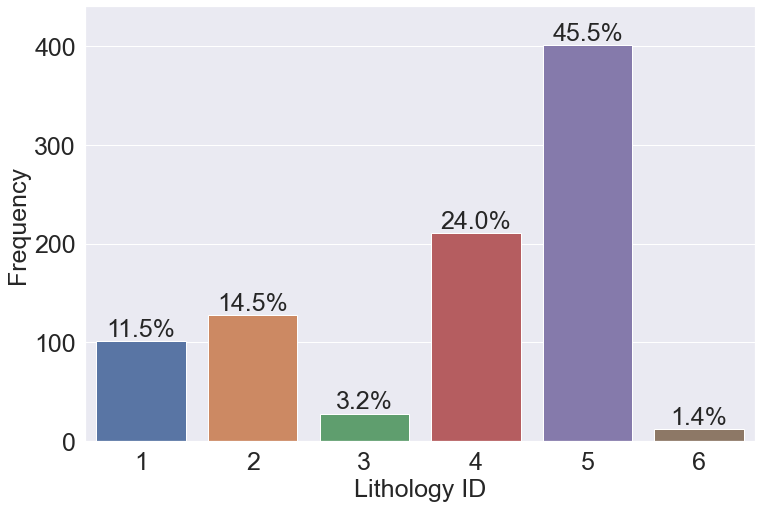

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
sns.set(font_scale = 1.5)
ax= sns.countplot(x="LithID", data=data)
ax.set_ylabel('Frequency', fontsize= 25)
ax.set_xlabel('Lithology ID', fontsize= 25)
ax.tick_params(axis='both', which='major', labelsize=25)

plt.ylim([0, 440])
ncount = len(data)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), size=25,
            ha='center', va='bottom') # set the alignment of the text
plt.savefig('Lithology.png')

In [143]:
data['LithID'].value_counts()/data.shape[0]*100

5    45.516459
4    23.950057
2    14.528944
1    11.464245
3     3.178207
6     1.362089
Name: LithID, dtype: float64

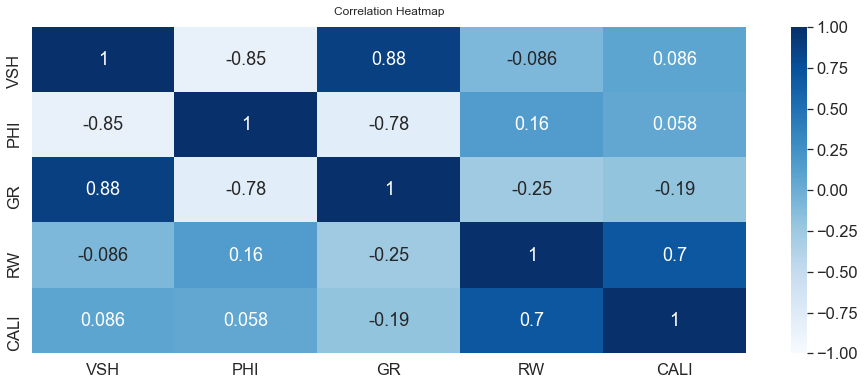

In [30]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data[['VSH', 'PHI', 'GR', 'RW', 'CALI']].corr(), vmin=-1, vmax=1, annot=True, cmap= 'Blues')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig('CC.png')

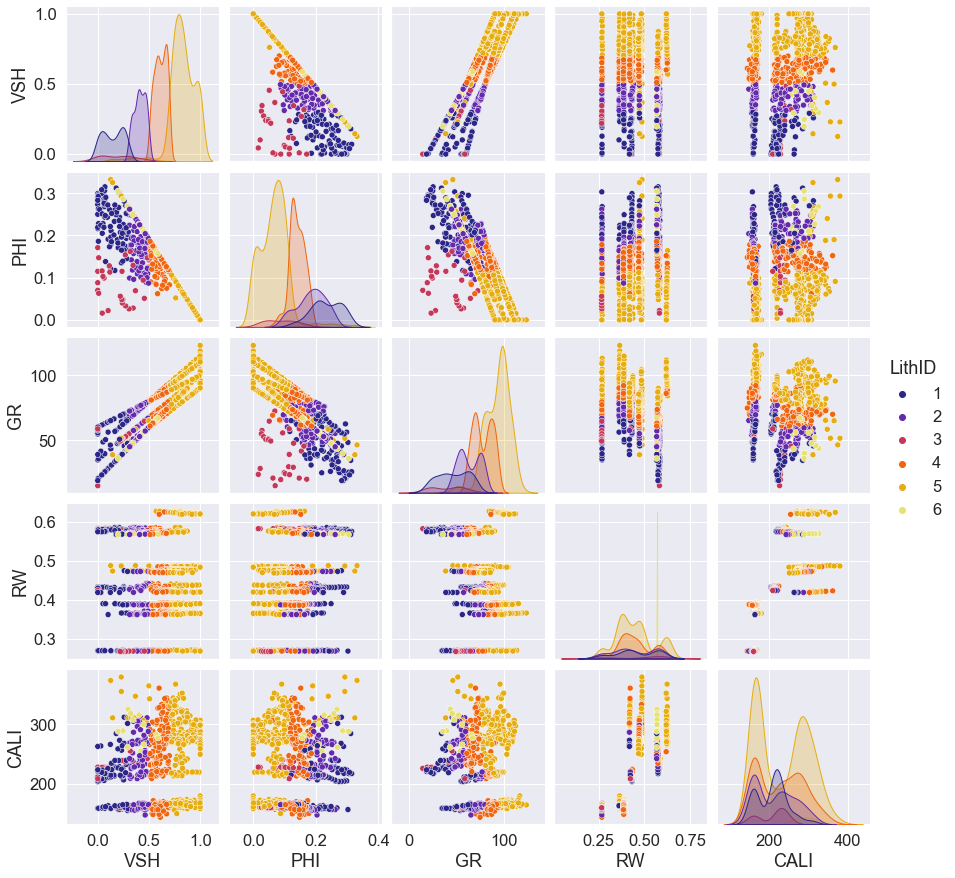

In [29]:
data.LithID = data.LithID.astype('category')
sns.set(font_scale=1.5)
sns.pairplot(data, vars= ['VSH', 'PHI', 'GR', 'RW', 'CALI'], hue='LithID', palette = 'CMRmap')
plt.savefig('pair.png')

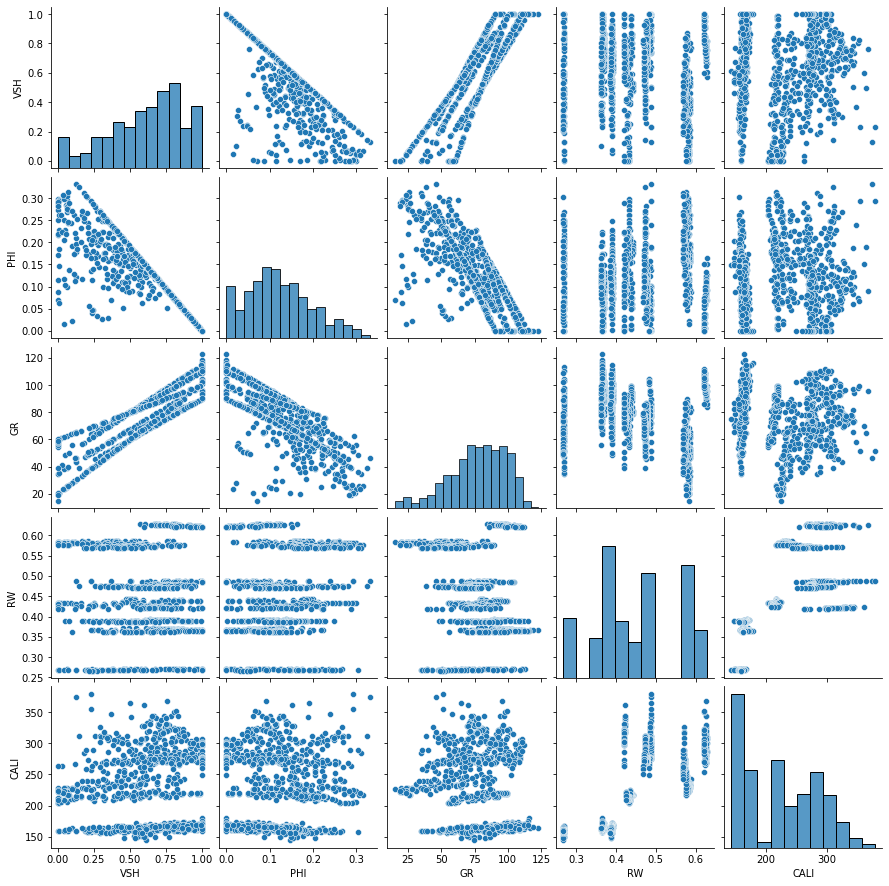

In [82]:
sns.pairplot(data, vars= ['VSH', 'PHI', 'GR', 'RW', 'CALI'], palette = 'CMRmap')

In [15]:
# the name of the file
file_name = 'CompiledData.xlsx'
  
# saving the excel
data.to_csv(file_name)

In [86]:
from platform import python_version

print(python_version())

3.8.8


In [87]:
!jupyter --version

jupyter core     : 4.7.1
jupyter-notebook : 6.3.0
qtconsole        : 5.0.3
ipython          : 7.22.0
ipykernel        : 5.3.4
jupyter client   : 6.1.12
jupyter lab      : 3.0.14
nbconvert        : 6.0.7
ipywidgets       : 7.6.3
nbformat         : 5.1.3
traitlets        : 5.0.5
